# Torchvision Maskrcnn on Volpy Data

Created by Changjia Cai, Erik Thompson, and Manuel Paez 

Date Created: August 28, 2024
Date Updated: January 08, 2025

Optional if you want qt

In [1]:
# %matplotlib qt
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.color import rgb2gray, gray2rgb
from skimage.draw import polygon2mask

import torchvision
from torchvision import tv_tensors
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
import colorsys
import random
import cv2
import torch
from torch.optim.lr_scheduler import CyclicLR
import torchvision
from torchvision.tv_tensors import Mask, BoundingBoxes
# IMport the augmentation transforms using both apis (functional and transform)
from torchvision.transforms.v2 import functional as F
import torchvision.transforms.v2 as T
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from utils import distance_masks, find_matches, nf_match_neurons_in_binary_masks, norm_nrg
from utils import ScaleImage, vp_load_image, plot_volpy_segs, draw_bbox, bounding_box
from utils import create_mask, box_area, normalize_image, random_colors, apply_mask
from utils import apply_masks, draw_bbox, collate_fn, draw_bboxes, thresholded_predictions
from utils import mrcnn_inference

from model import get_model_instance_segmentation

In [5]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


# 1. Inspect VolPy training data (Optional)

First, download the Volpy Training Data Files from here: 

Then, Set up directories as follows:

    volpy_training_data/
        images/
            HPC.29.04.npz
            ...
        masks/
            HPC.29.04_mask.npz
            ...        
            
The following `data_dir` variable should be directed to `volpy_training_data`

In [9]:
data_dir = '/Users/manuelpaez/Documents/Flatiron/Caiman/data/volpy_training_data/' 

image_dir = data_dir + 'images/' 
image_dir = data_dir + 'images/' 
image_path_list = list(sorted(os.listdir(os.path.join(data_dir, "images"))))
mask_path_list = list(sorted(os.listdir(os.path.join(data_dir, "masks"))))

Let's do some cursory inspection of one dataset. Note each image is three channels, but isn't RGB: channels one and two are mean, channel three is corr image.

In [10]:
# load one image and masks
dat_ind = 12
data_path = image_path_list[dat_ind]  
mask_path = mask_path_list[dat_ind] 
print(f'image name: {data_path}')
print(f'mask name: {mask_path}')

data_loaded = np.load(data_dir + 'images/' + data_path)
masks_loaded = np.load(data_dir + 'masks/' + mask_path, allow_pickle=True)

image = data_loaded['img']
masks = masks_loaded['mask']
image_gray = rgb2gray(image)
num_masks = len(masks)
print(f'image shape: {image.shape}, number of masks: {num_masks}')

image name: L1.00.00.npz
mask name: L1.00.00_mask.npz
image shape: (512, 128, 3), number of masks: 79


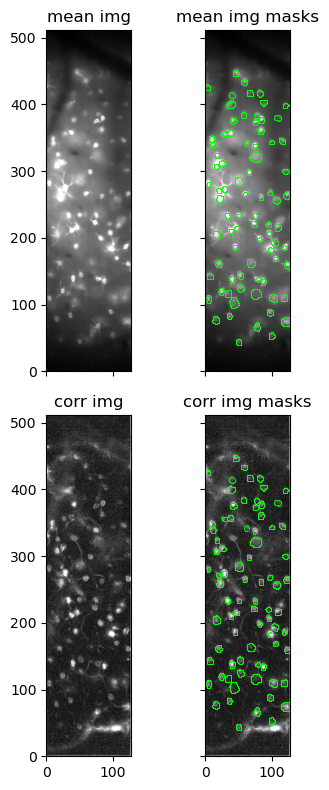

In [11]:
image_tensor = torch.from_numpy(image).permute(2,0,1)
image_tensor = tv_tensors.Image(image_tensor)
max_v = 99
outline_color = 'lime'
outline_width = 0.75
figsize = (4,8)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=figsize, sharex=True, sharey=True)  # w/h

# mean img
ax1.imshow(image[:,:,1], cmap='gray', vmax=np.percentile(image[:,:,1], max_v))
ax1.set_title('mean img')
ax2.imshow(image[:,:,1], cmap='gray', vmax=np.percentile(image[:,:,1], max_v))
for mask in masks:
    ax2.plot(mask['all_points_x'], mask['all_points_y'], 
             color=outline_color, linewidth=outline_width)
ax2.set_title('mean img masks')

# corr img
ax3.imshow(image[:,:,2], cmap='gray', vmax=np.percentile(image[:,:,2], max_v))
ax3.set_title('corr img')
ax4.imshow(image[:,:,2], cmap='gray', vmax=np.percentile(image[:,:,2], max_v))
for mask in masks:
    ax4.plot(mask['all_points_x'], mask['all_points_y'], 
             color=outline_color, linewidth=outline_width)
ax4.set_title('corr img masks')
plt.xlim([0, image.shape[1]-1])
plt.ylim([0, image.shape[0]-1])
plt.tight_layout()

# Define the Dataset
Built on the `torch.utils.data.Dataset`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html


The  `__getitem__` method should return an `image` and a `target` dictionary delineating the different objects (box/mask) in the image:

    image: torchvision.tv_tensors.Image of shape [3, H, W]: can be a pure tensor, or a PIL Image of size (H, W)
    target: a dict containing the following keys
        masks : torchvision uint8 binary masks for each object (N,H,W) (N masks)
        boxes (bounding boxes)  (nx4)
        labels (int) label for each bounding box (note 0 is background, so if you have no bg, start with 1)
        image_id (int) unique image id
        area (float) area of bounding box (I'm not sure this is technically required)
        iscrowd (uint8) instances with `iscrowd=True` will be ignored during evaluation 

In [12]:
image_scaler = ScaleImage()  

class NeuralDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.image_filenames = list(sorted(os.listdir(os.path.join(self.root, "images"))))
        self.mask_filenames = list(sorted(os.listdir(os.path.join(self.root, "masks"))))

    def __getitem__(self, idx):
        image_id = idx

        # Image: (C x H x W)
        image_path = os.path.join(self.root, "images", self.image_filenames[idx])
        image = np.load(image_path)['img'] # mean/mean/corr channels  (h w c)
        image = torch.from_numpy(image).permute(2,0,1) # convert to tensor and get into pytorch order C x H x W
        image = image_scaler(image)   # scale so it is in 0,1 range
        image = tv_tensors.Image(image)

        # Masks: N x H x W mask array (N masks)
        mask_path = os.path.join(self.root, "masks", self.mask_filenames[idx])
        masks_loaded = np.load(mask_path, allow_pickle=True)
        masks = masks_loaded['mask']
        # first create boolean mask stack
        all_masks = []
        for mask_ind, mask_dict in enumerate(masks): # [mask_ind]
            mask = create_mask(image[1].shape, mask_dict)
            all_masks.append(mask)
        all_masks = np.array(all_masks)
        # then convert to binary uint8 tensor stack
        all_masks = torch.from_numpy(all_masks.astype(np.uint8))
                
        boxes = masks_to_boxes(all_masks)
        box_areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])  # tensor of areas

        # there is only one class, so labels are all ones
        num_objs = len(masks)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        # let's just say nstances are not crowd: all instances will be used for evaluation
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap up everything into a dictionary describing target
        target = {}
        target["image_id"] = image_id
        target["masks"] = tv_tensors.Mask(all_masks)
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
        target["labels"] = labels
        target["area"] = box_areas
        target["iscrowd"] = iscrowd

        # run augmentation, if transforms exist
        if self.transforms is not None:
            image, target = self.transforms(image, target)
            
        return image, target
        
    def __len__(self):
        return len(self.image_filenames)
        
    def print_image_filenames(self):
        for image_filename in self.image_filenames:
            print(image_filename)

    def print_mask_filenames(self):
        for mask_filename in self.mask_filenames:
            print(mask_filename)

# Volpy Training Details

From the Volpy Paper:

> During training, we randomly cropped the input image into *128x128 patches* and applied the following data augmentation techniques using the imgaug package:
> 
>   `flip, rotation, multiply (adjust brightness), Gaussian noise, shear, scale and translation` 
>
> Each mini-batch contained *six patches*. We trained on one GPU the head (the whole network except the ResNet) of the network for 20 epochs (2000 iterations) with learning rate 0.01 and then trained the head together with the last 28 layers of the ResNet for another 20 epochs with learning rate 0.001. 
>
> We used stochastic gradient descent as our optimizer with a constant learning momentum 0.9. The weight decay was 0.0001. It is possible that correlations among RGB channels existing in the original COCO datasets are not present in our datasets, however retraining some of the ResNet layers is likely compensating for this potential issue. 
>
> It roughly took 40 minutes to train 40 epochs on a GeForce RTX 2080 Ti GPU with 11 GB of RAM memory. During validation, images were padded with zeroes to make width and height multiples of 64 so that feature maps could be smoothly scaled for the Feature Pyramid Network. We only selected neurons with confidence level greater or equal to 0.7. 
>
> The output components of the network were further filtered based on the number of pixels in each mask. For TEG datasets, masks containing less than 100 pixels were removed. For HPC datasets, masks containing pixels less than 400 were removed. For L1 datasets, there was no constraint on the number of pixels for each mask. VolPy segmentation performance is shown in Fig 3.

### Data Transforms

In [13]:
# flip, rotation, multiply (adjust brightness), Gaussian Noise, Shear, Scale and Translation
def data_transform(train=False):
    transform_pipeline = []
    if train:
        print("Generating training transform pipeline")
        transform_pipeline.append(T.ColorJitter(brightness=0.5,
                                                contrast=0.5,
                                                saturation=0.5,
                                                hue=0.2))
        transform_pipeline.append(T.GaussianBlur(kernel_size=(5,5), 
                                                         sigma=(0.001, 0.3)))  
        transform_pipeline.append(T.RandomHorizontalFlip(p=0.5))
        transform_pipeline.append(T.RandomVerticalFlip(p=0.5))
        # transform_pipeline.append(T.GaussianNoise())
        transform_pipeline.append(T.RandomRotation(4, fill=0, expand=False))  
        transform_pipeline.append(T.SanitizeBoundingBoxes(min_size=2))  
        
    # Convert to proper type and compose
    transform_pipeline.append(T.ToDtype(torch.float32, scale=True))
    transform_pipeline.append(T.ToPureTensor())
    return T.Compose(transform_pipeline)

print('transform updated')

transform updated


## Dataset Check: 
Set 'train=True.`

In [14]:
num_torch_workers = 0 # for windows set to 0, otherwise set to 4+ or whatever
volpy_data = NeuralDataset(data_dir, data_transform(train=True))
volpy_dataloader = torch.utils.data.DataLoader(volpy_data,
                                               batch_size=6,
                                               shuffle=True,
                                               num_workers=num_torch_workers,
                                               collate_fn=collate_fn)
print(len(volpy_data))

Generating training transform pipeline
24


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.4977883].


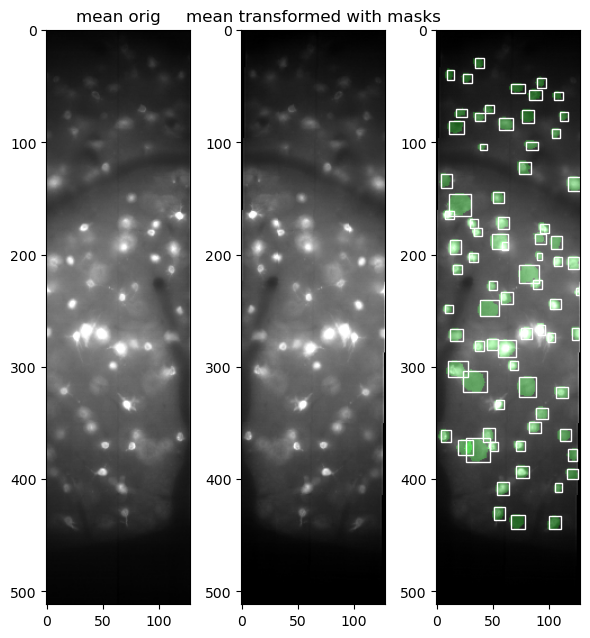

In [15]:
session_ind = 17
orig_image, orig_image_path = vp_load_image(image_dir, image_path_list, session_ind) # orig data and masks
dataset_image, dataset_target = volpy_data[session_ind] # data after transformation

summary_mn = gray2rgb(normalize_image(dataset_image[1,:,:]))
summary_corr = gray2rgb(normalize_image(dataset_image[2,:,:]))
data_masks = dataset_target['masks']
data_boxes = dataset_target['boxes']

# visualize transformed data
mask_color = (0, 1, 0)
plot_box = True
box_color = 'white'
alpha = 0.001

masked_mn_vp = apply_masks(summary_mn, data_masks, mask_color, alpha=alpha)
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(6, 12))
ax1.imshow(orig_image[:,:,0], cmap='gray', vmax=np.percentile(orig_image[:,:,0], 99.5))
ax1.set_title('mean orig')
ax2.imshow(summary_mn[:, :, 0], cmap='gray',  vmax=np.percentile(summary_mn, 99.5))
ax2.set_title('mean transformed')
ax3.imshow(masked_mn_vp)
ax2.set_title('mean transformed with masks')
if plot_box:
    ax3, rects = draw_bboxes(data_boxes, color=box_color, line_width=1, ax=ax3);
plt.tight_layout()

## Dataloader Check

Dataloader is an iterable. To create an iterator need to `iter(data_loader)`, then can run `next()` to pull the batch out of it that training is run. 

In [16]:
batch_images, batch_targets = next(iter(volpy_dataloader))

# standard way of extracting images and targets for a batch into a list
batch_images = list(image for image in batch_images)
batch_targets = [{k: v for k, v in t.items()} for t in batch_targets]

# check one sample
batch_ind = 0
batch_item_target = batch_targets[batch_ind]
batch_item_image = batch_images[batch_ind]
batch_item_id = batch_item_target['image_id']

# extract original image so we can compare
image_orig, image_orig_path = vp_load_image(image_dir, image_path_list, batch_item_id)

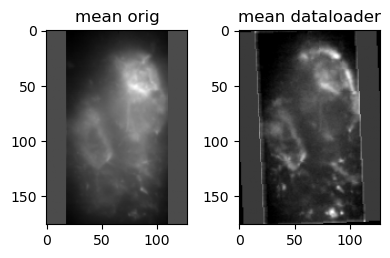

In [17]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(4,8))
ax1.imshow(image_orig[:,:,0], cmap='gray')
ax1.set_title('mean orig')
ax2.imshow(batch_item_image[0,:,:], cmap='gray')
ax2.set_title('mean dataloader')
plt.tight_layout()

# Setup for Training
Create a model generator to be ready to be trained and evaluated on the custom dataset.

## Define model
We will start from a pre-trained model trained on the coco dataset, and fine-tune the last layer.

We have two classes (background and neuron). Split into train and validation set.

In [18]:
# use our dataset and defined transformations
num_classes = 2
num_test = 8

# training and test datasets defined (this will determine which transforms are applied)
dataset = NeuralDataset(data_dir, data_transform(train=True))
dataset_val = NeuralDataset(data_dir, data_transform(train=False))

# here we select two thirds of datasets for training, one third of datasets for testing
# we make sure each type of datasets (L1, TEG, HPC) has at least one dataset for testing
indices = [4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 22, 23, 0, 1, 2, 3, 12, 13, 14, 21]
dataset = torch.utils.data.Subset(dataset, indices[:-num_test])
dataset_val = torch.utils.data.Subset(dataset_val, indices[-num_test:])

print(f'training sets: {indices[:-num_test]}')
print(f'test sets: {indices[-num_test:]}')

num_torch_workers = 0  # this is necessary for windows. In other OS set to 4+
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle=True,
                                          num_workers=num_torch_workers,
                                          collate_fn=collate_fn);
data_loader_val = torch.utils.data.DataLoader(dataset_val,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=num_torch_workers,
                                               collate_fn=collate_fn)

print(f'number of batches per epoch for training {len(data_loader)}')

Generating training transform pipeline
training sets: [4, 5, 6, 7, 8, 9, 10, 11, 15, 16, 17, 18, 19, 20, 22, 23]
test sets: [0, 1, 2, 3, 12, 13, 14, 21]
number of batches per epoch for training 8


Get the model using our helper function and move to the correct device:

In [19]:
model = get_model_instance_segmentation(num_classes)
model.to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/manuelpaez/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|█████████████████████████████████████████████████| 170M/170M [00:02<00:00, 78.5MB/s]


## Set up optimizer/lr scheduler

Note: If the learning rate is too high initially, you can get NaNs and error during training

In [20]:
max_lr = 0.005
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,
                            lr=max_lr, # 0.003
                            momentum=0.9,
                            weight_decay=0.0001) #0.0005
optimizer.param_groups[0]["lr"]  # to extract the learning rate

lr_scheduler = CyclicLR(optimizer, 
                     base_lr = 0.000001,     # Initial learning rate which is the lower boundary in the cycle for each parameter group
                     max_lr = max_lr,       # 0.003 Upper learning rate boundaries in the cycle for each parameter group
                     step_size_up = 3,     # Number of training iterations in the increasing half of a cycle
                     step_size_down = 7,
                     mode = "triangular2")

## Run training


In [21]:
model_save_dir = '/Users/manuelpaez/Documents/Flatiron/Caiman/models/'
try:
    os.mkdir(model_save_dir)
except:
    pass

num_epochs = 100
print_freq = 1
save_freq = 20
num_train = len(dataset)
num_val = len(dataset_val)

In [22]:
all_train_losses = []
all_val_losses = []
all_lrs = []

print(f"**TRAIN {num_epochs} epochs. PRINT every {print_freq} epoch(s). SAVE every {save_freq} epoch(s).**")

for epoch in range(num_epochs):      
    train_epoch_loss = 0
    val_epoch_loss = 0

    ### TRAIN STEP
    if np.mod(epoch+1, print_freq) == 0:
        print(f"Epoch {epoch+1}")
    #    print("\tTraining step...")
        
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum([loss for loss in loss_dict.values()])
        train_epoch_loss += losses.cpu().detach().numpy()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    all_train_losses.append(train_epoch_loss)
    all_lrs.append(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation STEP
    #if np.mod(epoch+1, print_freq) == 0:
    #    print("\tTest step...")
    with torch.no_grad():
        for j, (images_val, targets_val) in enumerate(data_loader_val):
            images_val = list(image.to(device) for image in images_val)
            targets_val = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets_val]
            loss_val = model(images_val, targets_val)
            losses_val = sum([l for l in loss_val.values()])
            val_epoch_loss += losses_val.cpu().detach().numpy()
        all_val_losses.append(val_epoch_loss)
        
    if np.mod(epoch+1, print_freq) == 0:
        print("\ttrain/test net loss: ", train_epoch_loss, " ", val_epoch_loss)

    # Save model (if save)
    if np.mod(epoch+1, save_freq) == 0:
        print(f"\tSaving mrcnn epoch {epoch+1}")
        model_fname = 'mrcnn_' + str(epoch+1) + '.pt'
        model_path = model_save_dir + model_fname
        torch.save(model, model_path)

    torch.cuda.empty_cache()  # may help with memory management
        
history = [all_train_losses, all_val_losses, all_lrs]
torch.save(history, model_save_dir + 'volpy_train_history.pt')
print("\nDONE!")    

**TRAIN 100 epochs. PRINT every 1 epoch(s). SAVE every 20 epoch(s).**
Epoch 1
	train/test net loss:  52.09875702857971   54.282936811447144
Epoch 2
	train/test net loss:  22.938624620437622   15.324891686439514
Epoch 3
	train/test net loss:  15.043523669242859   13.150779068470001
Epoch 4
	train/test net loss:  13.43206000328064   12.895792424678802
Epoch 5
	train/test net loss:  12.989299654960632   11.516741156578064
Epoch 6
	train/test net loss:  12.636343836784363   11.51409363746643
Epoch 7
	train/test net loss:  12.211486101150513   11.793972074985504
Epoch 8
	train/test net loss:  12.852209329605103   12.136046290397644
Epoch 9
	train/test net loss:  12.741521954536438   11.690398395061493
Epoch 10
	train/test net loss:  13.094074487686157   12.090694606304169
Epoch 11
	train/test net loss:  12.556044101715088   11.9241583943367
Epoch 12
	train/test net loss:  12.532343983650208   11.541896522045135
Epoch 13
	train/test net loss:  12.727223515510559   12.073652625083923
Epoch 14

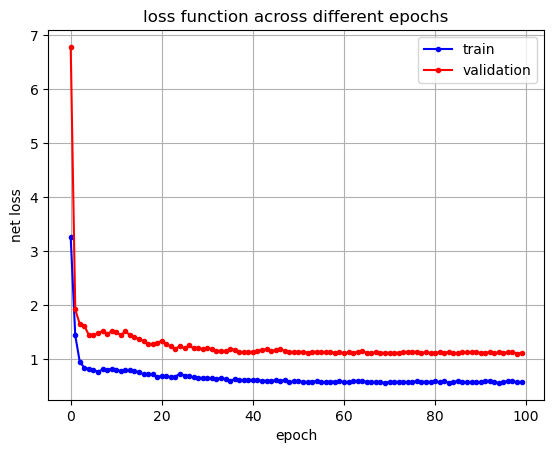

In [23]:
# plot loss function
plt.plot(np.array(all_train_losses)/num_train, color='blue', marker='.', label='train')
plt.plot(np.array(all_val_losses)/num_test, color='red', marker='.', label='validation')
plt.legend();
plt.xlabel('epoch')
plt.ylabel('net loss')
plt.title('loss function across different epochs')
plt.grid()

Text(0.5, 1.0, 'learning rate across different epochs')

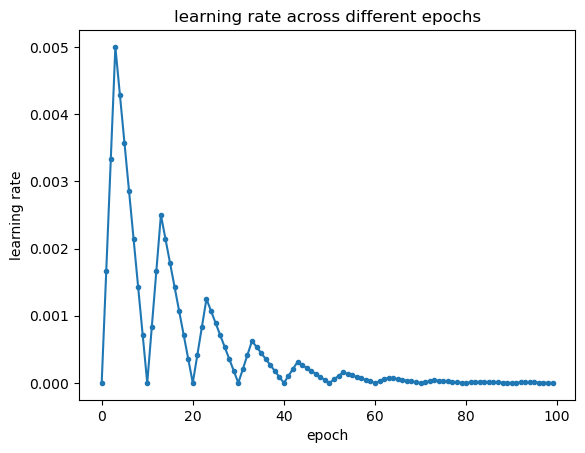

In [24]:
# plot learning rate vs epoch:
plt.plot(all_lrs, marker='.')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.title('learning rate across different epochs')

# Inference using Test Set

In [25]:
# pull original data 
idx = 4
val_set = np.array([0, 1, 2, 3, 12, 13, 14, 21])
volpy_inference_dataset = NeuralDataset(data_dir, data_transform(train=False))
vp_im, vp_target = volpy_inference_dataset[val_set[idx]]
summary_mn = gray2rgb(normalize_image(vp_im[1,:,:]))
summary_corr = gray2rgb(normalize_image(vp_im[2,:,:]))
data_masks = vp_target['masks']
data_boxes = vp_target['boxes']

In [26]:
# run inference on one dataset
eval_transform = data_transform(train=False)
model.eval()
with torch.no_grad():
    x = eval_transform(vp_im)
    x = x.to(device)
    predictions = model([x, ])
    pred = predictions[0]

# prediction score range
print(f'prediction scores: {pred["scores"]}')

prediction scores: tensor([0.9057, 0.9055, 0.8995, 0.8974, 0.8970, 0.8933, 0.8894, 0.8835, 0.8830,
        0.8797, 0.8780, 0.8689, 0.8676, 0.8661, 0.8646, 0.8637, 0.8565, 0.8531,
        0.8524, 0.8518, 0.8511, 0.8466, 0.8443, 0.8434, 0.8386, 0.8383, 0.8365,
        0.8346, 0.8340, 0.8326, 0.8305, 0.8266, 0.8228, 0.8210, 0.8199, 0.8178,
        0.8167, 0.8159, 0.8129, 0.8124, 0.8120, 0.8090, 0.7998, 0.7976, 0.7892,
        0.7875, 0.7853, 0.7834, 0.7804, 0.7759, 0.7747, 0.7740, 0.7726, 0.7701,
        0.7665, 0.7529, 0.7523, 0.7448, 0.7344, 0.7244, 0.7126, 0.7118, 0.7063,
        0.6858, 0.6854, 0.6833, 0.6582, 0.6300, 0.6119, 0.6105, 0.6014, 0.5747,
        0.5616, 0.5204, 0.4485, 0.4464, 0.4423, 0.3984, 0.3529, 0.3507, 0.3412,
        0.3058, 0.2989, 0.2850, 0.2723, 0.2696, 0.2694, 0.2527, 0.2457, 0.2409,
        0.2357, 0.2356, 0.2341, 0.2165, 0.2016, 0.1970, 0.1915, 0.1793, 0.1564,
        0.1496])


In [27]:
thresh = 0.5
predicted_masks, predicted_boxes = thresholded_predictions(pred, threshold=thresh) 
predicted_masks_np = (((0.5+predicted_masks).detach().cpu().numpy())).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.254].


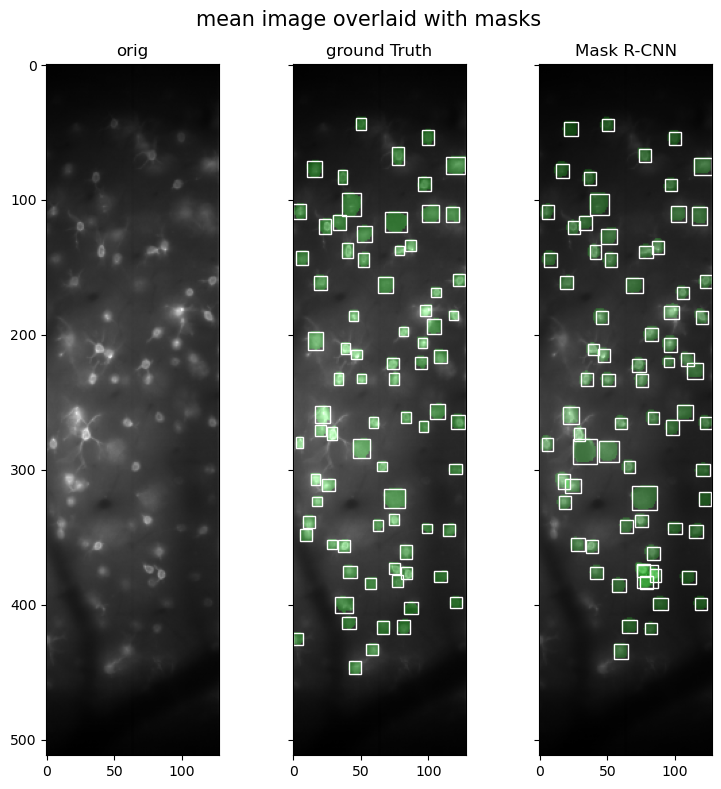

In [28]:
# get masked image of ground truth and predictions
mask_alpha = 0.001
mask_color = (0,1,0)
masked_vp = apply_masks(summary_mn, data_masks, color=mask_color, alpha=mask_alpha) 
masked_pred = apply_masks(summary_mn, predicted_masks_np, color=mask_color, alpha=mask_alpha)
masked_pred = masked_pred/masked_pred.max()

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(8,8), sharex=True, sharey=True)
ax1.imshow(summary_mn)
ax2.imshow(masked_vp)
ax3.imshow(masked_pred)
if plot_box:
    ax2, rects = draw_bboxes(data_boxes, ax=ax2, line_width=1, color='white');
    ax3, rect = draw_bboxes(predicted_boxes.detach().cpu().numpy(), ax=ax3, color='white', line_width=1);
ax1.set_title('orig')
ax2.set_title('ground Truth')
ax3.set_title('Mask R-CNN')
plt.suptitle('mean image overlaid with masks', fontsize=15)
plt.tight_layout();

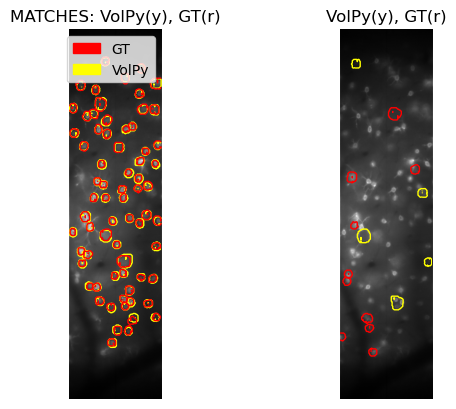

F1 score: 0.9019607843137255


<Figure size 640x480 with 0 Axes>

In [29]:
# compute F1 score for this dataset
_, _, _, _, performance = nf_match_neurons_in_binary_masks(data_masks.numpy().astype(np.float64), 
                                 predicted_masks_np.astype(np.float64), 
                                 plot_results=True, Cn=summary_mn, 
                                 labels=['GT', 'VolPy'], 
                                 colors=['red', 'yellow'])
print(f"F1 score: {performance['f1_score']}")

In [ ]:
def mrcnn_inference(model, img, thresh=0.5):
    """
    inference using Mask R-CNN network
    """
    model.eval()
    with torch.no_grad():
        x = eval_transform(img)
        x = x.to(device)
        predictions = model([x, ])
        pred = predictions[0]
    
    predicted_masks, predicted_boxes = thresholded_predictions(pred, threshold=thresh) 
    binarized_masks = (0.5+predicted_masks).detach().cpu().numpy().astype(np.uint8) 
    return predicted_masks, predicted_boxes, binarized_masks

In [30]:
# compute F1 score on all test sets
val_set = np.array([0, 1, 2, 3, 12, 13, 14, 21])
eval_transform = data_transform(train=False)
F1_all = []

for idx in val_set:
    vp_im, vp_target = volpy_inference_dataset[idx]
    summary_mn = gray2rgb(normalize_image(vp_im[1,:,:]))
    data_masks = vp_target['masks']
    _, _, binarized_masks = mrcnn_inference(model, img=vp_im, thresh=0.5)    

    try:
        _, _, _, _, performance = nf_match_neurons_in_binary_masks(data_masks.numpy().astype(np.float64), 
                                         binarized_masks.astype(np.float64), 
                                         plot_results=True, Cn=summary_mn, 
                                         labels=['GT', 'VolPy'], 
                                         colors=['red', 'yellow'])
        print(f"F1 score: {performance['f1_score']}")
        F1_all.append(performance['f1_score'])
        
    except:
        print(0)
        F1_all.append(0)
        

F1_all = np.array(F1_all)    
print(f'avg F1 score for HPC: {F1_all[:4].mean()}')
print(f'avg F1 score for L1: {F1_all[4:7].mean()}')
print(f'avg F1 score for TEG: {F1_all[7]}')

NameError: name 'mrcnn_inference' is not defined